<a href="https://colab.research.google.com/github/MOvations/Colab-Notebooks/blob/master/PreProcessing_Tickers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# if a different import meathod is needed
# %%capture
# !pip install -U quandl;
# !pip install -U fbprophet;
# !pip install -U quantecon;
# !pip install -U zipline;

In [ ]:
# Basics:
import numpy as np
import pandas as pd
import datetime as dt

# Solvers:
import cvxopt as opt
from cvxopt import blas, matrix, solvers
solvers.options['show_progress'] = False    # to turn off display as running

# Sources:
import fix_yahoo_finance as fyf

# Plotting: 
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-whitegrid')  #Best for White Backgrounds
plt.style.use('dark_background')     #Best for Black Backgrounds
%matplotlib inline

# %load_ext zipline
# from zipline.utils.factory import load_bars_from_yahoo  

In [ ]:
# easy manual portfolio import meathod
tickers = 'FB AMZN GOOG INTC CBRE KO DJP IAU GLD'
tickers = tickers.split()

end = pd.Timestamp.utcnow() 
# Go back 2500 business days 
start = end - 2500 * pd.tseries.offsets.BDay()

# start = '2016-10-01'
# # end = str(dt.date.today().strftime('%Y-%m-%d'))
# end = dt.datetime.strftime(dt.datetime.now() - dt.timedelta(1), '%Y-%m-%d')
print(end)


# import from file
######## TBD FUTURE WORK #########

# get all the data
data_raw = fyf.download(tickers, start)

# just what we need for now
data = data_raw['Adj Close']
data.tail()

2019-09-24 03:10:21.075076+00:00
[*********************100%***********************]  9 of 9 downloaded


,AMZN,CBRE,DJP,FB,GLD,GOOG,IAU,INTC,KO
Date,,,,,,,,,
2019-09-17,1822.550049,53.900002,22.430000,188.080002,141.600006,1229.150024,14.36,51.950001,54.240002
2019-09-18,1817.459961,53.919998,22.290001,188.139999,140.710007,1232.410034,14.27,51.740002,54.230000
2019-09-19,1821.500000,53.849998,22.330000,190.139999,141.279999,1238.709961,14.34,51.570000,54.520000
2019-09-20,1794.160034,53.540001,22.299999,189.929993,142.949997,1229.930054,14.51,50.720001,53.910000
2019-09-23,1785.300049,52.779999,22.430000,186.820007,143.750000,1234.030029,14.59,50.900002,54.139999


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


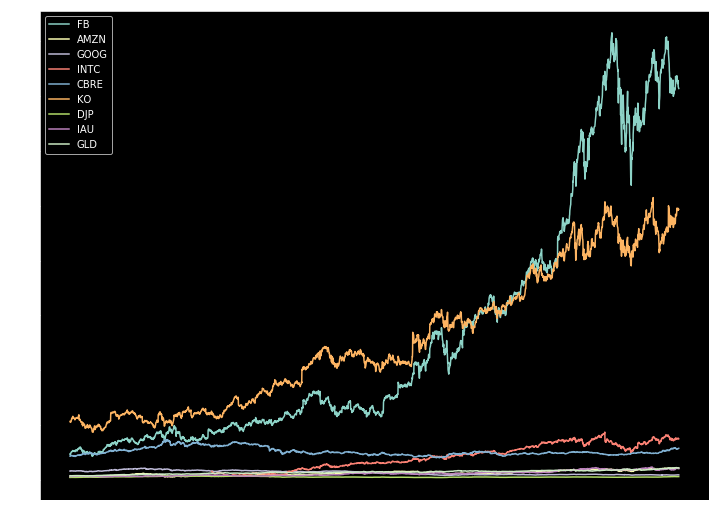

In [ ]:
# plot raw imported data
plt.figure(figsize=(12,9))
plt.plot(data)
plt.legend(tickers, loc=2)

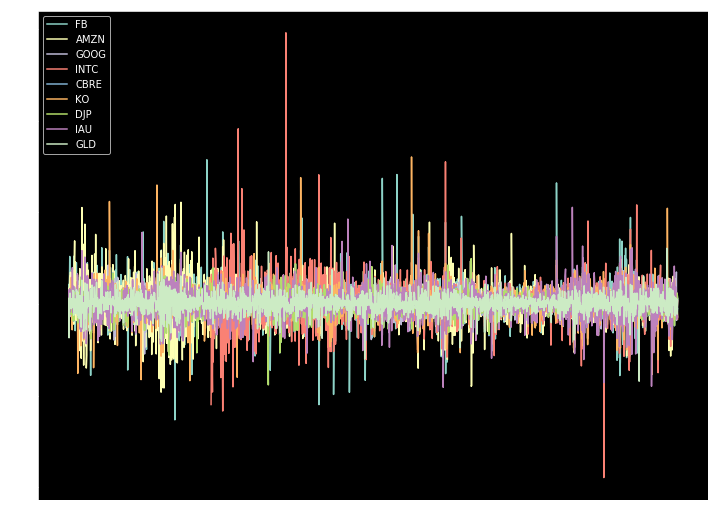

In [ ]:
# calculate to returns
norm_rets = data.pct_change()[1:]
log_rets = np.log(data/data.shift(1))[1:]

plt.figure(figsize=(12,9))
plt.plot(norm_rets)
plt.legend(tickers, loc=2)

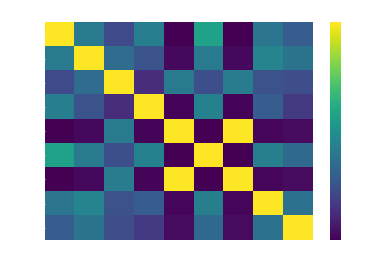

In [ ]:
# Correlations
corrs = data.pct_change(1).corr()
sns.heatmap(corrs, cmap='viridis')
plt.title('Porfolio Correlations');


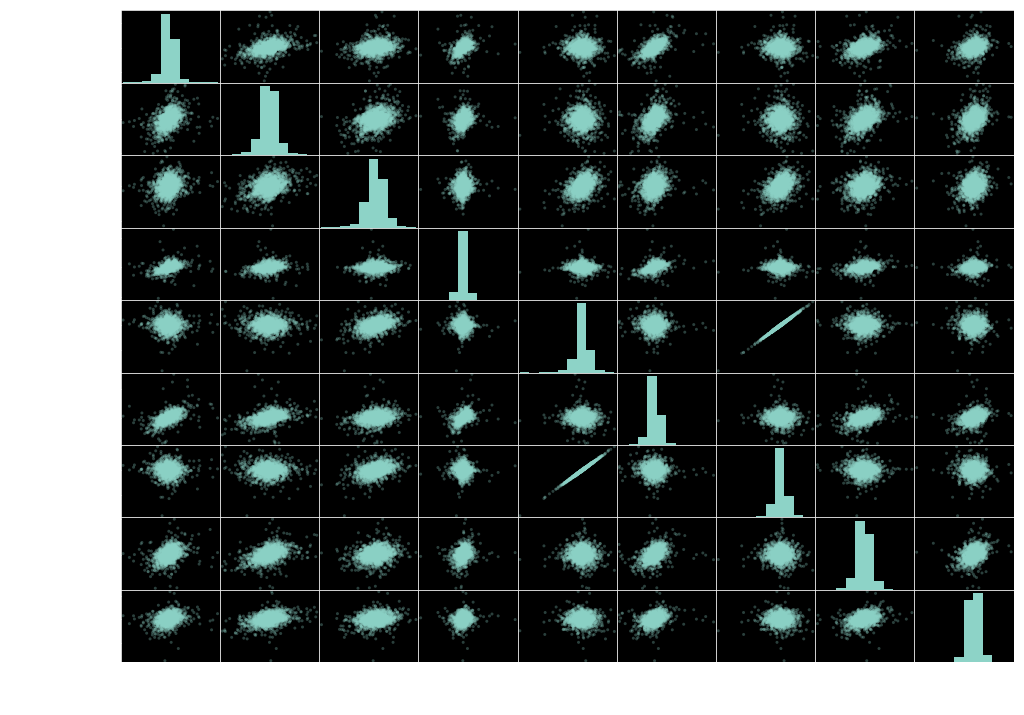

In [ ]:
scatter_matrix(log_rets, figsize=(16,12), alpha=0.3);

In [ ]:
norm_rets.describe()

,AMZN,CBRE,DJP,FB,GLD,GOOG,IAU,INTC,KO
count,2412.000000,2412.000000,2412.000000,1847.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000
mean,0.001323,0.000787,-0.000197,0.001121,0.000167,0.000755,0.000173,0.000621,0.000481
std,0.019723,0.020154,0.009172,0.023066,0.009787,0.015532,0.009796,0.015456,0.009334
min,-0.126568,-0.096333,-0.054663,-0.189609,-0.087808,-0.083775,-0.088459,-0.091020,-0.084354
25%,-0.008204,-0.009200,-0.005684,-0.009120,-0.004876,-0.006501,-0.004798,-0.007806,-0.004369
50%,0.001103,0.000887,0.000000,0.000847,0.000394,0.000484,0.000091,0.000624,0.000498
75%,0.011621,0.010842,0.005202,0.011862,0.005168,0.008507,0.005164,0.008860,0.005586
max,0.157457,0.111038,0.042467,0.296115,0.049038,0.160524,0.049505,0.105519,0.060718


In [ ]:
# Markowitz Stuff
def optimal_portfolio(returns):
  """ Takes innput of Returns as np.array (n-assets x m-measurments) \n
  Returns weights, risks, and returns(np.asmatrix) of balanced portfolio"""

  n = len(returns)
  returns = np.asmatrix(returns)
  
  N = 100
  # mus = [10**(5.0 * t/N - 1.0) for t in range(N)] #WRONG, needs to start at 0
  mus = [ ((10**(5.0*t/N-1.0)) - .1) for t in range(N) ] 
  
  # Convert to cvxopt matrices
  S = opt.matrix(np.cov(returns))
  pbar = opt.matrix(np.mean(returns, axis=1))
  
  # Create constraint matrices
  # G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
  # h = opt.matrix(0.0, (n ,1))

  G = -opt.matrix(np.eye(n))
  h = opt.matrix(0.0, (n,1))

  A = opt.matrix(1.0, (1, n))
  b = opt.matrix(1.0)
  # b = opt.matrix(0.15)

  # G = matrix(0.0, (n,n))
  # G[::n+1] = -1.0               # negative n x n identity matrix
  # h = matrix(0.0, (n,1))
  # A = matrix(1.0, (1,n))
  # b = matrix(1.0)
  
  # Calculate efficient frontier weights using quadratic programming
  portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                for mu in mus]
  ## CALCULATE RISKS AND RETURNS FOR FRONTIER
  returns = [blas.dot(pbar, x) for x in portfolios]
  risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
  ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
  m1 = np.polyfit(returns, risks, 2)
  x1 = np.sqrt(abs(m1[2] / m1[0]))           # add abs to prevent returning NaN

  # CALCULATE THE OPTIMAL PORTFOLIO
  wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
  return np.asarray(wt), returns, risks

# https://stackoverflow.com/questions/23833329/how-do-i-use-cvxopt-for-mean-variance-optimization-with-constraints
# https://www.quantopian.com/posts/the-efficient-frontier-markowitz-portfolio-optimization-in-python

In [ ]:

## NUMBER OF ASSETS
n_assets = len(tickers)
## NUMBER OF OBSERVATIONS
n_obs = int(norm_rets.describe().iloc[0,1])   # ASSUMES the same for all assets

norm_rets.to_numpy().T.shape

(9, 2412)

In [ ]:
# NOTE need to convert returns from df to a np array befor passing
np.set_printoptions(suppress=True)
weights, opt_rets, risks = optimal_portfolio(norm_rets.to_numpy().T)
 
order_target_percent = list(zip(norm_rets.columns, weights))

[ print(order_target_percent[x]) for x in range(order_target_percent.__len__()) ]

ValueError: ignored

There's a problem with these weights as they don't allow for more granularity - they only choose the best. Resouces are availible [here](https://www.quantopian.com/posts/the-efficient-frontier-markowitz-portfolio-optimization-in-python) and [here](https://stackoverflow.com/questions/23833329/how-do-i-use-cvxopt-for-mean-variance-optimization-with-constraints)

In [ ]:
# plot raw imported data
plt.figure(figsize=(12,9))
# plt.plot(stds, means, 'o', markersize=5)
plt.plot(norm_rets.std(), norm_rets.mean(), 'o', markersize=5)
plt.plot(risks, opt_rets, 'y-o')
# plt.legend(tickers, loc=2)